In [1]:
import os
os.chdir("../..")

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
use_contrastive = True
num_tasks = 4
num_epochs = 100

In [4]:
seed_everything(0)

data_cfg = {
    "dataset_name": "mnist",
    "num_tasks": num_tasks,
    "num_train_per_task": 128,
    "num_val_per_task": 102,
    'remap_labels': True,
    'use_contrastive': use_contrastive,
}
dataset = get_dataset(**data_cfg)

INFO:root:Class sequence: [5 0 3 4 2 6 7 1 8 9]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)


In [5]:
seed_everything(7)
sender_dataset1 = get_dataset(**data_cfg)

INFO:root:Class sequence: [9 5 7 8 4 3 6 1 0 2]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)


In [6]:
seed_everything(9)
sender_dataset2 = get_dataset(**data_cfg)

INFO:root:Class sequence: [9 1 6 5 2 0 4 8 3 7]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)


In [7]:
net_cfg = {
    'depth': 4,
    'layer_size': 64,
    'num_init_tasks': num_tasks,
    'i_size': 28,
    'num_classes': 2,
    'num_tasks': num_tasks,
    'dropout': 0.0,
}

agent_cfg = {
    'memory_size': 64,
    'use_contrastive': use_contrastive,
    'save_dir': 'test',
}

In [8]:
NetCls = MLPSoftLLDynamic
LearnerCls = CompositionalDynamicER
sharing_cfg = DictConfig({
    "scorer": "cross_entropy",
    "num_queries": 4,
    "query_score_threshold": 0.0,
})
train_cfg = {
    # "num_epochs": 40,
    "num_epochs": num_epochs,
}

agent = RecvDataAgent(0, 0, dataset,
                NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, 
                sharing_cfg)

sender1 = RecvDataAgent(1, 1, sender_dataset1,
                NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, 
                sharing_cfg)


sender2 = RecvDataAgent(2, 2, sender_dataset2,
                NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, 
                sharing_cfg)


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1001
INFO:root:Agent: node_id: 2, seed: 2002


In [9]:
for t in range(num_tasks):
    agent.train(t)
    sender1.train(t)
    sender2.train(t)

INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.69224913	acc: 0.524
INFO:root:	task: avg	loss: 0.69224913	acc: 0.524
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.69224913	acc: 0.524
INFO:root:	task: avg	loss: 0.69224913	acc: 0.524
INFO:root:final components: 4
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.69245004	acc: 0.531
INFO:root:	task: avg	loss: 0.69245004	acc: 0.531
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.69245004	acc: 0.531
INFO:root:	task: avg	loss: 0.69245004	acc: 0.531
INFO:root:final components: 4
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.70182215	acc: 0.471
INFO:root:	task: avg	loss: 0.70182215	acc: 0.471
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.70182215	acc: 0.471
INFO:root:	task: avg	loss: 0.70182215	acc: 0.471
INFO:root:final components: 4
INFO:root:epochs: 0, training task: 1
INFO:root:	task: 0	loss: 0.69224913	acc: 0.524
INFO:root:	task: 1	lo

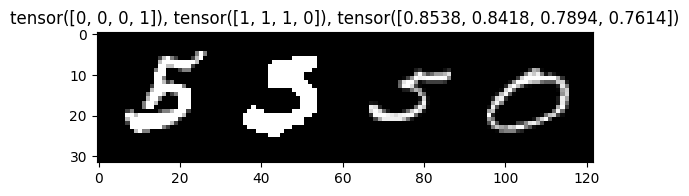

In [10]:
qX, qY, ypred, scores = agent.compute_query(task_id=0, mode="current", debug_return=True)
qX = qX[0]
qY = qY[0]
ypred = ypred[0]
scores = scores[0]

q_plt = make_grid(qX)
plt.imshow(q_plt.permute(1, 2, 0))
# plotting the query
plt.title(f"{qY}, {ypred}, {scores}");

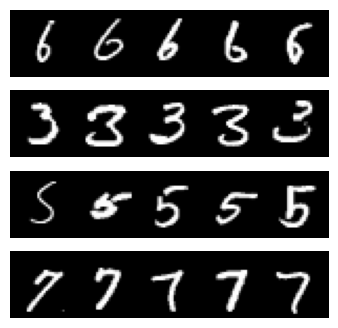

In [11]:
neighbors, neighbor_prefilter = sender1.new_nearest_neighbors(qX, n_neighbors=5, 
                            #   n_filter_neighbors=10,
                              n_filter_neighbors=5,
                              debug=True)
neigbors = neighbors.cpu()
# plot the neighbors per row
n_X = neighbors.shape[0]
fig, ax = plt.subplots(n_X, 1, figsize=(20, 4))
for i in range(n_X):
    n_plt = make_grid(neighbors[i].cpu())
    ax[i].imshow(n_plt.permute(1, 2, 0))
    ax[i].axis('off')

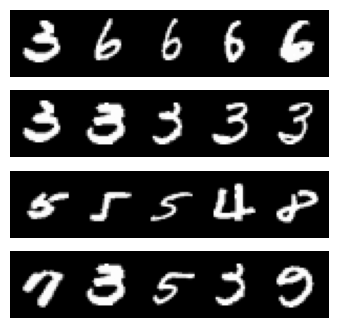

In [12]:
neighbor_prefilter = neighbor_prefilter.cpu()
# plot the pre-filter neighbors per row
n_X = neighbor_prefilter.shape[0]
fig, ax = plt.subplots(n_X, 1, figsize=(20, 4))
for i in range(n_X):
    n_plt = make_grid(neighbor_prefilter[i].cpu())
    ax[i].imshow(n_plt.permute(1, 2, 0))
    ax[i].axis('off')

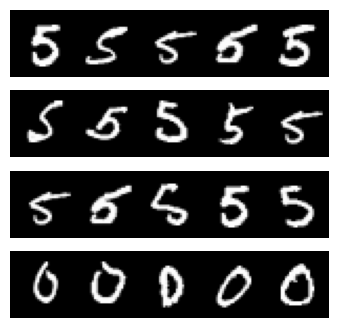

In [13]:
neighbors2, neighbor_prefilter2 = sender2.new_nearest_neighbors(qX, n_neighbors=5, 
                            #   n_filter_neighbors=10,
                              n_filter_neighbors=5,
                              debug=True)
neigbors2 = neighbors2.cpu()
# plot the neighbors per row
n_X2 = neighbors2.shape[0]
fig, ax = plt.subplots(n_X2, 1, figsize=(20, 4))
for i in range(n_X2):
    n_plt = make_grid(neighbors2[i].cpu())
    ax[i].imshow(n_plt.permute(1, 2, 0))
    ax[i].axis('off')

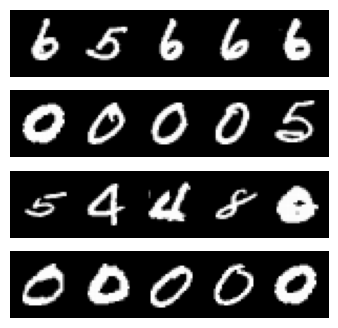

In [14]:
neighbor_prefilter2 = neighbor_prefilter2.cpu()
# plot the pre-filter neighbors per row
n_X2 = neighbor_prefilter2.shape[0]
fig, ax = plt.subplots(n_X2, 1, figsize=(20, 4))
for i in range(n_X2):
    n_plt = make_grid(neighbor_prefilter2[i].cpu())
    ax[i].imshow(n_plt.permute(1, 2, 0))
    ax[i].axis('off')

In [18]:
agent.compute_query(task_id=3)

{0: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [